In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchsummary import summary

import numpy as np
import datetime
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

from tqdm import tqdm
import glob
from PIL import Image

### **Google Drive linking and other operations for saving some data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PATH_DRIVE = '/content/drive/My Drive/UNIMORE/cDCGAN' # Path on Google Drive where to save data (trained models and generation samples)

Mounted at /content/drive


In [3]:
verbose = False
torch.manual_seed(1)
NOISE_VECTOR_DIM = 100
MODEL_NAME = 'ConditionalDeepConvolutionalGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(PATH_DRIVE + '/samples'):
  os.makedirs(PATH_DRIVE + '/samples')

if not os.path.exists(PATH_DRIVE + '/samples/gif_dir'):
  os.makedirs(PATH_DRIVE + '/samples/gif_dir')

if not os.path.exists(PATH_DRIVE + '/training_models'):
  os.makedirs(PATH_DRIVE + '/training_models')

if not os.path.exists(PATH_DRIVE + '/training_models/Discriminator'):
  os.makedirs(PATH_DRIVE + '/training_models/Discriminator')

if not os.path.exists(PATH_DRIVE + '/training_models/Generator'):
  os.makedirs(PATH_DRIVE + '/training_models/Generator')

# **Project start**

In [18]:
def to_onehot(x, num_classes=10):
  '''
  One-Hot encoding of MNIST classes to use as model input (with noise vector).

  returns:
    - one-hot encoding of input vector with class labels.
  '''
  assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
  if isinstance(x, int):
    c = torch.zeros(1, num_classes).long()
    c[0][x] = 1
  else:
    x = x.cpu()
    c = torch.LongTensor(x.size(0), num_classes)
    c.zero_()
    c.scatter_(1, x, 1) # dim, index, src value
  return c


def get_sample_images(G, num_samples):
  '''
  Generate num_samples noise vector from latent space and pass to Generator
  as input in order to get sample images.

  returns:
    num_samples generate images
  '''
  samples_per_line = int(np.sqrt(num_samples))
  matrix_img = np.zeros([28 * samples_per_line, 28 * samples_per_line])
  for j in range(10):
    c = torch.zeros([10, 10]).to(DEVICE)
    c[:, j] = 1
    z = torch.randn(samples_per_line, NOISE_VECTOR_DIM).to(DEVICE)
    y_hat = G(z,c).view(samples_per_line, 28, 28)
    result = y_hat.cpu().data.numpy()
    matrix_img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
  return matrix_img
    

def make_gif(frame_folder, duration):
  '''
  Make a gif from generated samples during the training in order to see
  the improvement of the generator.

  returns:
    save a gif on google drive directory
  '''
  a = [image for image in glob.glob(f"{frame_folder}/*.jpg")]
  imgs = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.jpg")]
  for i in range(len(imgs)):
    plt.imshow(imgs[i], cmap='gray')
    plt.axis('off')
    plt.title('epoch: {}'.format(int(i* 50/len(imgs))))
    plt.savefig(frame_folder + 'gif_dir/img_%d.jpg' % int(i* 50/len(imgs)))


  a = [image for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  frames = [Image.open(image) for image in glob.glob(f"{frame_folder + '/gif_dir'}/*.jpg")]
  print('frames: {}'.format(len(frames)))
  frame_one = frames[0]
  frame_one.save(PATH_DRIVE + "/training_improvements.gif", format="GIF",
              append_images=frames, save_all=True, duration=duration, loop=0)

### **Dataset loading and preparation**

In [ ]:
#MNIST dataset preparation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
                              )

mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)


condition_size = 10

In [6]:
class Generator(nn.Module):
    '''
    Generator model definition.
    In the Conditional Deep Convolutional GAN it is defined as an CNN model with
    input size equal to noise vector plus the 10-class one-ho-encoding vector.
    The output size is the same as images we want to generate.
    (in this case is 1 x 28 x 28).
    The model has been divided into 3 blocks, and each block consists of:
    - A Convolution 2D Transpose Layer
    - Followed by a BatchNorm Layer and LeakyReLU Activation Function
    - A tanh Activation Function in the last block, instead of ReLU.

    Before process data through the CNN network, the input is preprocessed 
    in a fully connected layer that produce an output of size 4x4x512.
    '''
    def __init__(self, input_size=100, condition_size=10):
        super(Generator, self).__init__()
        
        self.fully_connected = nn.Sequential(
            nn.Linear(input_size+condition_size, 4*4*512),
            nn.ReLU(),
        )

        self.convolutional_network = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, c):
        # x: (N, 100), c: (N, 10)
        x, c = x.view(x.size(0), -1), c.float() # may not need
        noise_vector_with_class = torch.cat((x, c), 1) # v: (N, 110)
        y_ = self.fully_connected(noise_vector_with_class)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        generated_img = self.convolutional_network(y_) # (N, 28, 28)
        return generated_img

In [10]:
class Discriminator(nn.Module):
    '''
    Discriminator model definition as a binary classifier.
    In the Conditional Deep Convolutional GAN it is defined as an CNN model with
    input size equal to flattened image size plus the one-hot-ecnoding.
    The output size is the 1 (i.e. the probability of a binary problem -> real or fake).
    Before process data through the CNN network, the input is preprocessed 
    in a fully connected layer that produce an output of size 784 (1 x 28 x 28).
    '''
    def __init__(self, in_channel=1, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()

        self.transform = nn.Sequential(
            nn.Linear(input_size+condition_size, 784),
            nn.LeakyReLU(0.2),
        )

        self.convolutional_network = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )

        self.fully_connected = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, c):
        # x: (N, 1, 28, 28), c: (N, 10)
        x, c = x.view(x.size(0), -1), c.float() # may not need
        input = torch.cat((x, c), 1) # v: (N, 794)
        image_flattened_with_class = self.transform(input) # (N, 784)
        image_flattened_with_class = image_flattened_with_class.view(image_flattened_with_class.shape[0], 1, 28, 28) # (N, 1, 28, 28)
        y_ = self.convolutional_network(image_flattened_with_class)
        y_ = y_.view(y_.size(0), -1)
        output = self.fully_connected(y_)
        return output

## **Training phase**

In [11]:
#Models creation
num_samples = 100
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

#Loss function
adversarial_loss  = nn.BCELoss()

#Optimizer
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [12]:
max_epoch = 50 # epochs for training
step = 0
step_frequency = 1000 #frequency to save training samples in order to see G's improvements
n_critic = 1 # for training more k steps about Discriminator

D_loss_history = []
G_loss_history = []

D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

for epoch in tqdm(range(max_epoch), desc='cDCGAN training'):
    for idx, (real_images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = real_images.to(DEVICE)
        y = labels.view(batch_size, 1)
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y)
        D_x_loss = adversarial_loss(x_outputs, D_labels)

        z = torch.randn(batch_size, NOISE_VECTOR_DIM, 1, 1).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = adversarial_loss(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, NOISE_VECTOR_DIM).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = adversarial_loss(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_optimizer.step()

        if verbose:
            if step % 500 == 0:
                print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % step_frequency == 0:
            G.eval()
            img = get_sample_images(G, num_samples)
            imsave(PATH_DRIVE + '/samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
            
        step += 1
    

    D_loss_history.append(D_loss.item())
    G_loss_history.append(G_loss.item())

    torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/G_epoch_%d.pth' % (epoch))
    torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/D_epoch_%d.pth' % (epoch))

cDCGAN training: 100%|██████████| 50/50 [47:37<00:00, 57.15s/it]


## **Post training operations**

### **Plotting Generator and Discriminator's losses**

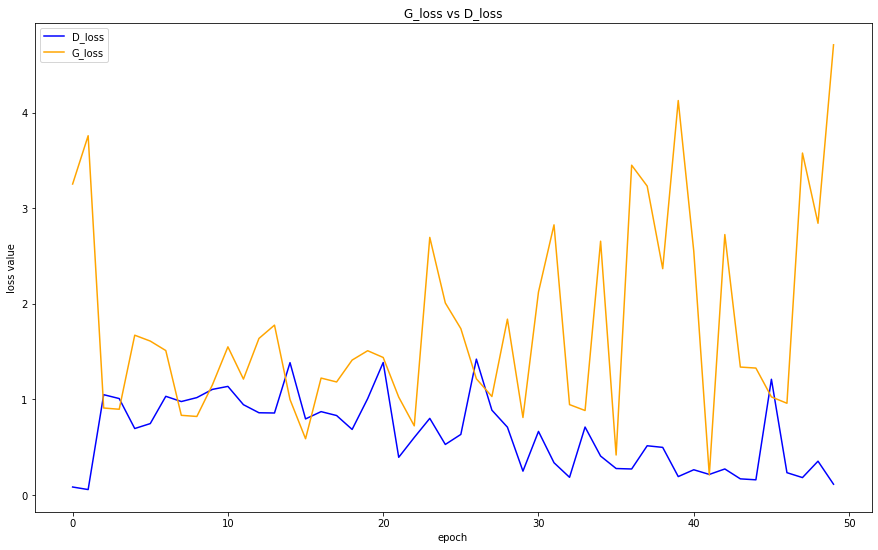

In [13]:
plt.figure(figsize=(15,9)) 
plt.plot(D_loss_history, color='blue', label='D_loss') #plot the data
plt.plot(G_loss_history, color='orange', label='G_loss') #plot the data
plt.ylabel('loss value') #set the label for y axis
plt.xlabel('epoch') #set the label for x-axis
plt.title("G_loss vs D_loss") #set the title of the graph
plt.legend()
plt.show() #display the graph

### **Plotting some sample images**

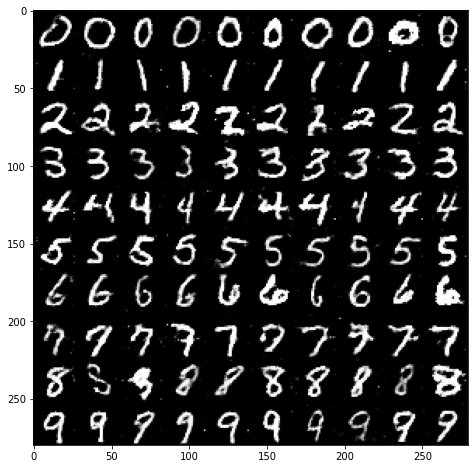

In [14]:
# generation to image
G.eval()
plt.figure(figsize=(8,8)) 
imshow(get_sample_images(G, num_samples), cmap='gray')

In [15]:
# Saving params
min_value = min(G_loss_history)
min_index = G_loss_history.index(min_value)
print(min_index)  #to see at which epoch the Generator has te lowest loss

# Saving models at last epoch of training
torch.save(D.state_dict(), PATH_DRIVE + '/training_models/Discriminator/Discriminator.pth')
torch.save(G.state_dict(), PATH_DRIVE + '/training_models/Generator/Generator.pth')

41


### **Loading model using pytorch**

In [16]:
G.load_state_dict(torch.load(PATH_DRIVE + '/training_models/Generator/G_epoch_41.pth'), strict=False)
G.eval()

Generator(
  (fully_connected): Sequential(
    (0): Linear(in_features=110, out_features=8192, bias=True)
    (1): ReLU()
  )
  (convolutional_network): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

### **Making a gif to see Generator's improvement during training**

frames: 47


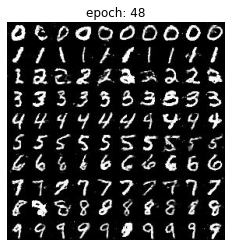

In [21]:
make_gif(PATH_DRIVE + '/samples/', 250)